# Collision likelihood

Let's consider a multi-device IoT scenario with both Poisson HMMs and Discrete HMMs.
The challenge of detecting collision likelihood becomes a structured learning problem.

### Problem Definition

- Inputs: Base station sees a time series of observed signals with possible collisions.

- Goal: Learn a model that predicts the probability of collision at each time step.

- Devices:
    - 20 devices with categorical emissions (e.g., Discrete HMM).
    - 5 devices with count-based Poisson emissions (e.g., Poisson HMM).

In [1]:
%%capture
!pip install scikit-learn

In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

## Step 1: Simulate Emissions

Simulate each device independently.

Sum up emissions and apply a collision function: If more than one device emits at the same time → collision Else → base station sees total emission.

In [4]:
from devices import SimpleHMM as DiscreteHMM
from devices import PoissonHMM

In [5]:
# Parameters
T = 1000
n_discrete = 20
n_poisson = 5

# HMM models (same for all devices of each type)
A_disc = np.array([[0.97, 0.03],   # idle → idle with high probability
                   [0.7, 0.3]])    # active → idle more likely than staying active

B_disc = np.array([[0.99, 0.01, 0.0],   # idle emits 0 with very high probability
                   [0.7, 0.25, 0.05]])  # active: mostly emits 0–1, rarely 2
pi_disc = [1.0, 0.0]

# Poisson-based HMM
A_pois = np.array([[0.98, 0.02],   # idle → idle is very likely
                   [0.6, 0.4]])    # active → idle more likely than staying active

lambda_pois = [0.05, 1.0]          # lower emission intensity

pi_pois = [1.0, 0.0]

In [6]:
def sample_discrete_hmm(T):
    device = DiscreteHMM(A_disc, B_disc, pi_disc)
    states, emissions = device.sample(T)
    return emissions

def sample_poisson_hmm(T):
    device = PoissonHMM(A_pois, lambda_pois, pi_pois)
    states, emissions = device.sample(T)
    return emissions  

In [7]:
# Generate emissions from all devices
emissions = []
for _ in range(n_discrete):
    emissions.append(sample_discrete_hmm(T))
for _ in range(n_poisson):
    emissions.append(sample_poisson_hmm(T))
emissions = np.array(emissions)

## Step 2: Create Dataset

For each time step:
- Input: scalar total emission (combined_obs[t])
- Label: 1 if collision occurred, 0 otherwise.

In [8]:
# Base station view: sum + collision label
total_emission = emissions.sum(axis=0)
active_devices = (emissions > 0).sum(axis=0)

collisions = (active_devices > 1).astype(int)

In [9]:
# Create features: [total_emission, num_active_devices (optional)]
X = total_emission.reshape(-1, 1)  # or np.vstack((total_emission, active_devices)).T
y = collisions

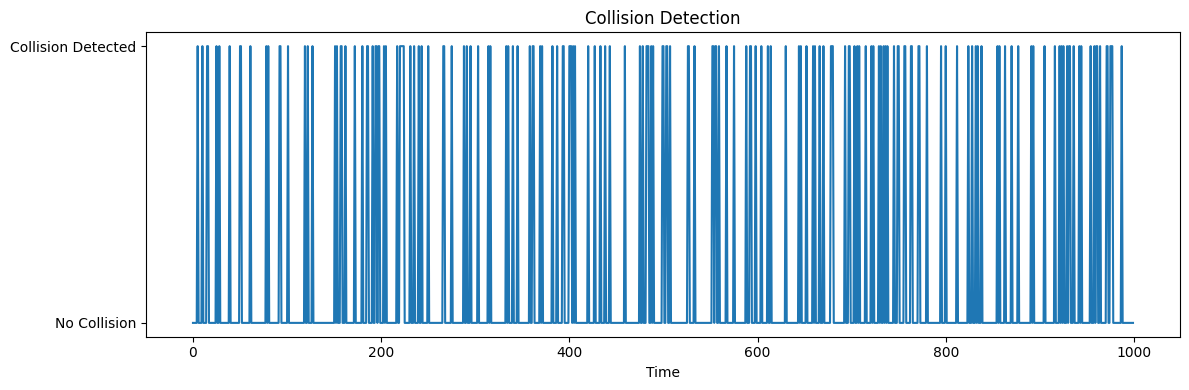

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(y, label="True collisions")
plt.xlabel("Time")
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.title("Collision Detection")
# plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Train a Model

Train a (lightweight) model (*e.g.* random forest, logistic regression, or a small neural net) to classify collision likelihood from the observable signal.

In [11]:
n_estimators = 10

In [12]:
# Split the data and 
split = int(0.8 * T)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [13]:
# train simple classifier

clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [14]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       164
           1       0.88      1.00      0.94        36

    accuracy                           0.97       200
   macro avg       0.94      0.98      0.96       200
weighted avg       0.98      0.97      0.98       200



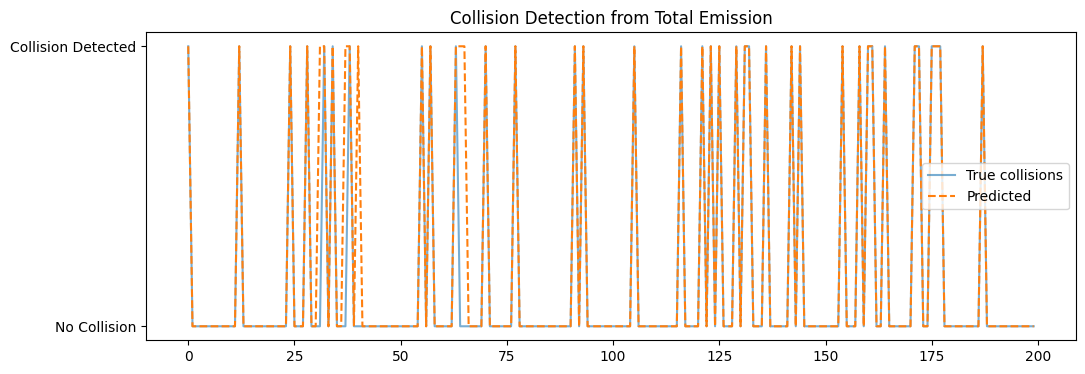

In [15]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True collisions", alpha=0.6)
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title("Collision Detection from Total Emission")
plt.show()

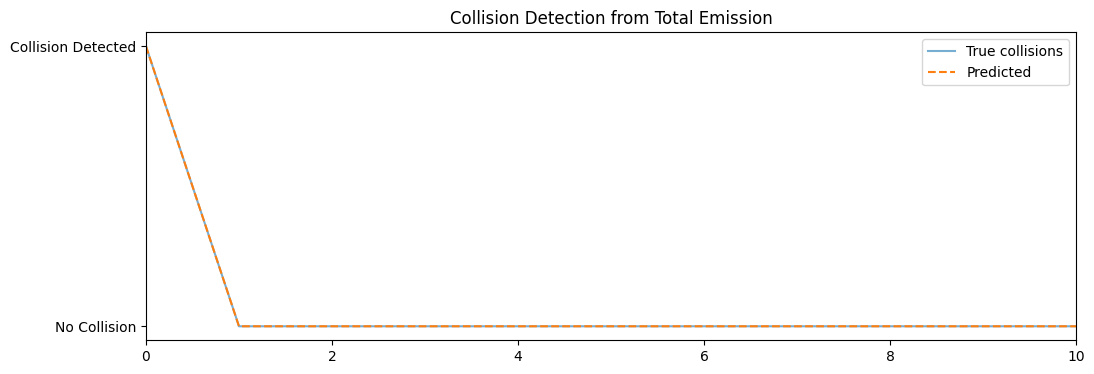

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True collisions", alpha=0.6)
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.xlim(0, 10)
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title("Collision Detection from Total Emission")
plt.show()

## Updated Strategy: Temporal Features

- Let's use recent history to better detect collision patterns

In [17]:
n_context = 3  # number of time steps to consider in the classification

In [18]:
X = []
y = []

for t in range(n_context - 1, T):
    context = total_emission[t - n_context + 1: t + 1]
    X.append(context)
    y.append(collisions[t])

X = np.array(X)
y = np.array(y)

In [19]:
# Split data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
# Train classifier
clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=6, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, n_estimators=10, random_state=42)

In [21]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       164
           1       0.88      0.97      0.92        36

    accuracy                           0.97       200
   macro avg       0.93      0.97      0.95       200
weighted avg       0.97      0.97      0.97       200



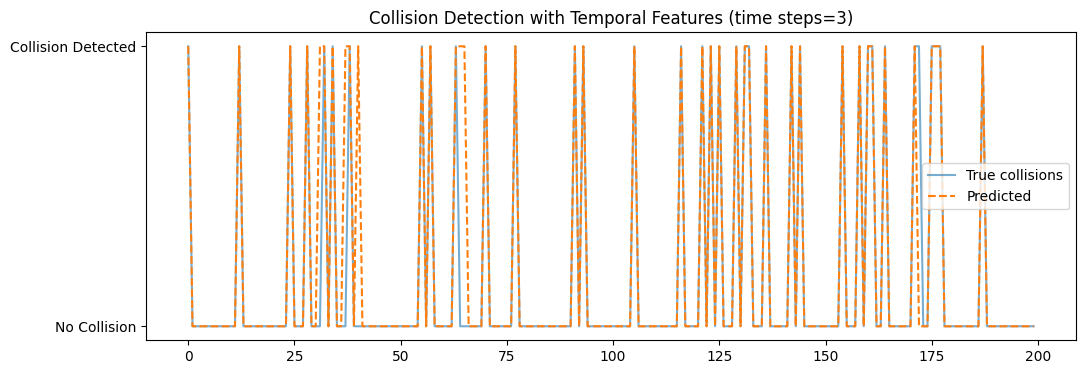

In [22]:
# Plot results
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True collisions", alpha=0.6)
plt.plot(y_pred, label="Predicted", linestyle='--')
plt.yticks([0, 1], ['No Collision', 'Collision Detected'])
plt.legend()
plt.title(f"Collision Detection with Temporal Features (time steps={n_context})")
plt.show()